In [1]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import AgglomerativeClustering
import scipy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm
import random
from scipy.stats import sem
import time
import h5py
import ants
import nibabel as nib
import matplotlib
from scipy.ndimage import gaussian_filter1d

/home/users/yandanw/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning:

Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function



In [2]:
func_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_287/func_0/'

In [3]:
# closed_loop_h5_file = os.path.join(func_path, 'visual', '20220806_114038.h5')
# f = h5py.File(closed_loop_h5_file, 'r')
# start_thetas = f.attrs['start_theta']

In [4]:
###########################
### PREP VISUAL STIMULI ###
###########################

vision_path = os.path.join(func_path, 'visual')
### Load Photodiode ###
t, ft_triggers, pd1, pd2 = brainsss.load_photodiode(vision_path)
stimulus_start_times = brainsss.extract_stim_times_from_pd(pd2, t)
### Unifrom the units and Make then intigers ###
stimulus_start_times = (stimulus_start_times*100).astype('int') #index needs to be an integers

####################
### Prep Fictrac ###
####################

fictrac_path = os.path.join(func_path, 'fictrac')
fictrac_raw = brainsss.load_fictrac(fictrac_path)

fps = 100
resolution = 10 #desired resolution in ms
expt_len = fictrac_raw.shape[0]/fps*1000
behaviors = ['dRotLabY', 'dRotLabZ', 'heading']
fictrac = {}
for behavior in behaviors:
    if behavior == 'dRotLabY': short = 'Y'
    elif behavior == 'dRotLabZ': short = 'Z'
    elif behavior == 'heading': short = 'h'
    fictrac[short] = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior)
    #fictrac[short] = np.roll(fictrac[short],400) # <------- misalignment is corrected !!!!!!
fictrac_timestamps = np.arange(0,expt_len,resolution)

fictrac['h'] = np.rad2deg(fictrac['h'])

def extract_traces(fictrac, stim_times, pre_window, post_window, behavior='Z'):
    traces = []
    for i in range(len(stim_times)):
        trace = fictrac[behavior][stim_times[i]-pre_window:stim_times[i]+post_window]
        if len(trace) == pre_window + post_window: # this handles fictrac that crashed or was aborted or some bullshit
            traces.append(trace)
    traces = np.asarray(traces)
    mean_trace = np.mean(traces,axis=0)
    sem_trace = scipy.stats.sem(traces,axis=0)
    return traces, mean_trace, sem_trace

loading photodiode data... done


In [5]:
n_clusters = 2000
cluster_dir = os.path.join(func_path, 'clustering')

load_file = os.path.join(cluster_dir, 'cluster_labels.npy')
cluster_labels = np.load(load_file)

load_file = os.path.join(cluster_dir, 'cluster_signals.npy')
all_signals = np.load(load_file)

In [6]:
all_signals.shape

timestamps = brainsss.load_timestamps(os.path.join(func_path, 'imaging'))

fixed = brainsss.load_fda_meanbrain()

atlas = brainsss.load_roi_atlas()

explosion_rois = brainsss.load_explosion_groups()
all_rois = brainsss.unnest_roi_groups(explosion_rois)
roi_masks = brainsss.make_single_roi_masks(all_rois, atlas)
roi_contours = brainsss.make_single_roi_contours(roi_masks, atlas)

def supervoxel_to_full_res(brain, cluster_labels):
    n_clusters = brain.shape[1]
    
    reformed_brain = []
    for z in range(49):
        colored_by_betas = np.zeros((256*128))
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_labels[z,:]==cluster_num)[0]
            colored_by_betas[cluster_indicies] = brain[z,cluster_num]
        colored_by_betas = colored_by_betas.reshape(256,128)
        reformed_brain.append(colored_by_betas)
    return np.asarray(reformed_brain)

Trying to load timestamp data from hdf5 file.
Success.


In [8]:
#heading = fictrac['h']-fictrac['h'][100]
heading = fictrac['h']
heading = heading%360

In [9]:
neural_file = os.path.join(func_path, 'functional_channel_2_moco_zscore_highpass.h5') #
with h5py.File(neural_file, 'r') as h:
    print(h['data'].shape)
    neural = h['data'][:]

(256, 128, 49, 3384)


In [10]:
from scipy.interpolate import interp1d as interp1d
def interpolate_to_neural(slice_num, timestamps):
    x = timestamps[:, slice_num]
    f = interp1d(fictrac_timestamps, heading, fill_value="extrapolate") 
    ynew = f(x)
    return ynew

In [11]:
bins = np.arange(-180,181,30)
all_slices = []
for z in range(49):
    print(z)
    slice_neural = neural[:,:,z,:]
    
    heading_interpolated = interpolate_to_neural(z,timestamps)
    ### redefine 0
    heading_interpolated -= 180
    
    avg_neural_barposition = []
    bin_middle = []
    for i in range(len(bins)-1):
        start = bins[i]
        stop = bins[i+1]
        bin_middle.append((start+stop)/2)
        ids = np.where(np.logical_and(heading_interpolated>start, heading_interpolated<=stop))[0]
        avg_neural_barposition.append(np.mean(slice_neural[:,:,ids],axis=2))
    all_slices.append(np.asarray(avg_neural_barposition))
all_slices = np.asarray(all_slices)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48


In [12]:
warps = brainsss.warp_STA_brain(STA_brain=np.rollaxis(all_slices,3,0), fly='fly_287', fixed=fixed, anat_to_mean_type='myr')

In [13]:
explosions = []
t0 = time.time()
for angle in range(12):
    input_canvas = np.ones((500,500,3)) #+.5 #.5 for diverging
    data_to_plot = warps[angle][:,:,::-1]
    vmax = 0.5
    explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                        roi_masks,
                                                        roi_contours,
                                                        data_to_plot,
                                                        input_canvas,
                                                        vmax=vmax,
                                                        cmap='seismic',
                                                        diverging=True)#'hot')
    explosions.append(explosion_map)

In [4]:
# ###########################
# ### PREP VISUAL STIMULI ###
# ###########################

# vision_path = os.path.join(func_path, 'visual')
# ### Load Photodiode ###
# t, ft_triggers, pd1, pd2 = brainsss.load_photodiode(vision_path)
# stimulus_start_times = brainsss.extract_stim_times_from_pd(pd2, t)
# ### Unifrom the units and Make then intigers ###
# stimulus_start_times = (stimulus_start_times*1000).astype('int') #index needs to be an integers


# # thetas = np.unique(start_thetas)
# # theta_categories = {}
# # for theta in thetas:
# #     idx = np.where(start_thetas==theta)[0]
# #     theta_categories[theta] = stimulus_start_times[idx]

    
    
    
# n_clusters = 2000
# cluster_dir = os.path.join(func_path, 'clustering')

# load_file = os.path.join(cluster_dir, 'cluster_labels.npy')
# cluster_labels = np.load(load_file)

# load_file = os.path.join(cluster_dir, 'cluster_signals.npy')
# all_signals = np.load(load_file)

loading photodiode data... done


In [14]:
# all_signals.shape

# timestamps = brainsss.load_timestamps(os.path.join(func_path, 'imaging'))

# fixed = brainsss.load_fda_meanbrain()

# atlas = brainsss.load_roi_atlas()

# explosion_rois = brainsss.load_explosion_groups()
# all_rois = brainsss.unnest_roi_groups(explosion_rois)
# roi_masks = brainsss.make_single_roi_masks(all_rois, atlas)
# roi_contours = brainsss.make_single_roi_contours(roi_masks, atlas)

# def supervoxel_to_full_res(brain, cluster_labels):
#     n_clusters = brain.shape[1]
    
#     reformed_brain = []
#     for z in range(49):
#         colored_by_betas = np.zeros((256*128))
#         for cluster_num in range(n_clusters):
#             cluster_indicies = np.where(cluster_labels[z,:]==cluster_num)[0]
#             colored_by_betas[cluster_indicies] = brain[z,cluster_num]
#         colored_by_betas = colored_by_betas.reshape(256,128)
#         reformed_brain.append(colored_by_betas)
#     return np.asarray(reformed_brain)

# bin_start = -2000; bin_end = 5000; bin_size = 200
# neural_bins = np.arange(bin_start,bin_end,bin_size)
# baseline_idx = 8 #-400ms

# np.where(neural_bins==-400)

all_explosions = {}
all_warps = {}
STA_brains = {}
for theta in thetas:
    event_times_list = theta_categories[theta]
    
    t0 = time.time()
    STA_brain = brainsss.make_STA_brain(neural_signals = all_signals,
                                       neural_timestamps = timestamps,
                                       event_times_list = event_times_list,
                                       neural_bins = neural_bins)
    print(F'STA {time.time()-t0}')

    reformed_STA_brain = brainsss.STA_supervoxel_to_full_res(STA_brain, cluster_labels)
    STA_brain = gaussian_filter1d(reformed_STA_brain,sigma=1,axis=1,truncate=1)
    STA_brains[theta] = STA_brain
    STA_brain -= STA_brain[:,baseline_idx,np.newaxis,:,:]
    
    
    t0 = time.time()
    warps = brainsss.warp_STA_brain(STA_brain=STA_brain, fly='fly_287', fixed=fixed, anat_to_mean_type='myr')
    all_warps[theta] = np.asarray(warps)

    print(F'Warps {time.time()-t0}')
    
    explosions = []
    t0 = time.time()
    for tp in range(len(neural_bins)-1):
        input_canvas = np.ones((500,500,3)) #+.5 #.5 for diverging
        data_to_plot = warps[tp][:,:,::-1]
        vmax = 0.5
        explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                            roi_masks,
                                                            roi_contours,
                                                            data_to_plot,
                                                            input_canvas,
                                                            vmax=vmax,
                                                            cmap='seismic',
                                                            diverging=True)#'hot')
        explosions.append(explosion_map)
    print(F'Explosion {time.time()-t0}')
    all_explosions[theta] = explosions

NameError: name 'thetas' is not defined

In [12]:
save_path = os.path.join(func_path,'figs','20230413a')
EB_mask = roi_masks[23]
for tp in range(len(neural_bins)-1):
    plt.figure(figsize=(10,10))
    for k,theta in enumerate(thetas):
        plt.subplot(1,5,k+1)
        masked_roi = EB_mask*all_warps[theta][tp,:,:,::-1]

        ### maximum projection along z-axis
        # works for negative values
        maxs = np.max(masked_roi,axis=2)
        mins = np.min(masked_roi,axis=2)
        maxs[np.where(np.abs(mins)>maxs)] = mins[np.where(np.abs(mins)>maxs)]

        plt.imshow(maxs.T,cmap='seismic',vmin=-.7,vmax=.7)
        plt.xlim(143,170)
        plt.ylim(70,43)
        plt.title(theta)
        plt.axis('off')
    plt.text(x=90,y=30,s=f'{neural_bins[tp]}ms',fontsize=14)
    save_file = os.path.join(save_path,str(tp).zfill(5))
    plt.savefig(save_file,dpi=300,bbox_inches='tight')
    plt.clf()
    plt.close()

NameError: name 'neural_bins' is not defined

In [16]:
plt.figure(figsize=(10,10))
tp=16
vec_thetas = []
for k,theta in enumerate(thetas):
    plt.subplot(1,5,k+1)
    masked_roi = EB_mask*all_warps[theta][tp,:,:,::-1]

    ### maximum projection along z-axis
    # works for negative values
    maxs = np.max(masked_roi,axis=2)
    mins = np.min(masked_roi,axis=2)
    maxs[np.where(np.abs(mins)>maxs)] = mins[np.where(np.abs(mins)>maxs)]
    data = maxs[144:171,43:70].T
    plt.imshow(data,cmap='seismic',vmin=-1,vmax=1)

    full_vector, normalized_vector, vec_theta = calc_avg_vector(data)
    plt.arrow(13, 13, normalized_vector['x'], normalized_vector['y'], head_width=2)
    
#     data = np.clip(data,0,None)
#     full_vector, normalized_vector, vec_theta = calc_avg_vector(data)
#     plt.arrow(13, 13, normalized_vector['x'], normalized_vector['y'], head_width=3)

    #plt.xlim(143,170)
    #plt.ylim(70,43)
    plt.title(theta)
    plt.axis('off')
    vec_thetas.append(vec_theta)

NameError: name 'thetas' is not defined

<Figure size 720x720 with 0 Axes>

In [220]:
vec_thetas[2]-vec_thetas

array([-55.10637133, -41.7669819 ,   0.        , -55.36766162,
        86.13717374])

In [207]:
vec_thetas

[164.52341829343953,
 151.18402885661635,
 109.41704696022953,
 164.78470857944944,
 23.27987322004422]

In [213]:
vec_thetas[2]-vec_thetas[4]

86.1371737401853

In [209]:
np.diff(vec_thetas)

array([ -13.33938944,  -41.7669819 ,   55.36766162, -141.50483536])

In [210]:
180-164+23

39

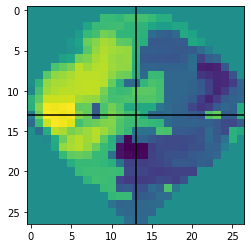

In [8]:
plt.imshow(maxs[144:171,43:70].T)
plt.axvline(13,color='k')
plt.axhline(13,color='k')

In [39]:
maxs[144:171,43:70].T.shape

(27, 27)

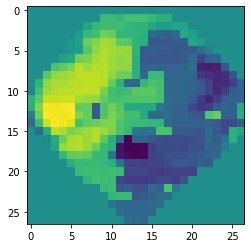

In [11]:
# NORMALIZE TO (0,0)
delta_max = maxs[144:171,43:70] - maxs[144:171,43:70][12][12]
plt.imshow(delta_max.T)

In [43]:
#a

In [76]:
## create new y-axis 
a = np.asarray(list(range(-13,14)))
a = a[:,np.newaxis]
ys = np.repeat(a, 27, axis=1)
ys = ys[::-1,:]
xs = ys.T[:,::-1]

In [41]:
ys.shape

(27, 27)

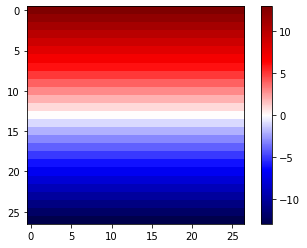

In [134]:
plt.imshow(ys,cmap='seismic')
plt.colorbar()

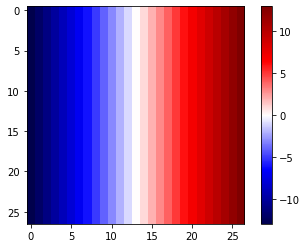

In [135]:
plt.imshow(xs,cmap='seismic')
plt.colorbar()

In [84]:
np.shape (ys**2 + xs**2)

(27, 27)

In [92]:
norm_origin = np.sqrt(ys**2 + xs**2)

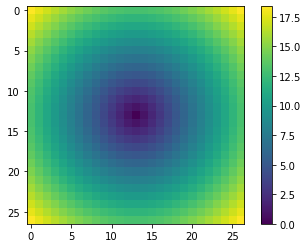

In [93]:
# length array 
plt.imshow(norm_origin)
plt.colorbar()

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning:

invalid value encountered in true_divide



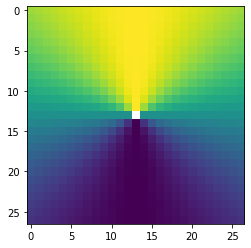

In [100]:
norm_ys = ys/norm_origin
#unit vector -- y-axis
plt.imshow(norm_ys)

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning:

invalid value encountered in true_divide



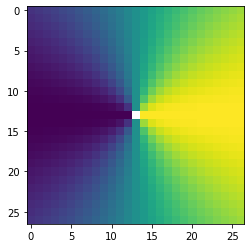

In [101]:
#unit vector -- x-axis
norm_xs = xs/norm_origin
plt.imshow(norm_xs)

In [126]:
maxs[144:171,43:70].T.shape

(27, 27)

In [15]:
def calc_avg_vector(data):
    #x_width = data.shape[0]
    #y_width = data.shape[1]
    width = 27
    
    ### create x and y position matricies
    a = np.asarray(list(range(-13,14)))
    a = a[:,np.newaxis]
    ys = np.repeat(a, width, axis=1)
    ys = ys[::-1,:]
    xs = ys.T[:,::-1]
    
    ### get length (from middle 0,0) of each voxel
    norm_origin = np.sqrt(ys**2 + xs**2)
    
    ### get unit vectors
    norm_xs = np.nan_to_num(xs/norm_origin)
    norm_ys = np.nan_to_num(ys/norm_origin)
    
    ### weight by neural data
    xs_contri = norm_xs * data
    ys_contri = norm_ys * data
    
    ### sum all vectors
    vector_x = np.sum(xs_contri)
    vector_y = np.sum(ys_contri)
    
    ### not sure why but some axis flipping and rotating is necessary
    theta = np.deg2rad(-90)
    rot = np.array([[cos(theta), -sin(theta)], [sin(theta), cos(theta)]])
    true_x = np.dot(rot,[vector_y,vector_x])[0]
    true_y = np.dot(rot,[vector_y,vector_x])[1]
    full_vector = {'x':true_x,'y':true_y}
    
    # also return the vector normalized to some length
    desired_length = 10
    length = (true_x**2+true_y**2)**.5
    norm_x = true_x / length * desired_length
    norm_y = true_y / length * desired_length
    
    normalized_vector = {'x':norm_x, 'y':norm_y}
    
    theta_cos = -normalized_vector['x']/ ((normalized_vector['x']**2+normalized_vector['y']**2)**.5)
    vec_theta = np.rad2deg(np.arccos(theta_cos))
    
    return full_vector, normalized_vector, vec_theta

In [171]:
vector_x, vector_y = calc_avg_vector(fake_data)

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning:

invalid value encountered in true_divide

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning:

invalid value encountered in true_divide



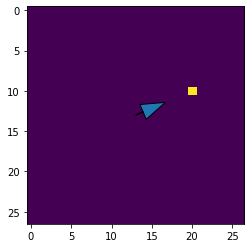

In [178]:
fake_data = np.zeros((27,27))
fake_data[10,20] = 1
plt.imshow(fake_data)
plt.arrow(13, 13, vector_x, vector_y, head_width=2)

#plt.axvline(13,color='w')
#plt.axhline(13,color='w')

In [183]:
full_vector, normalized_vector = calc_avg_vector(maxs[144:171,43:70].T)

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning:

invalid value encountered in true_divide

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning:

invalid value encountered in true_divide



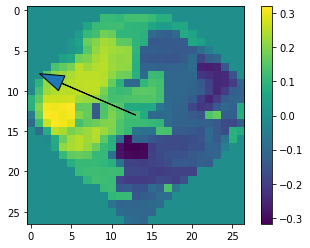

In [185]:
plt.imshow(maxs[144:171,43:70].T)
plt.arrow(13, 13, normalized_vector['x'], normalized_vector['y'], head_width=2)
plt.colorbar()

In [191]:
### calculate the theta of the vector
normalized_vector['x'], normalized_vector['y']

(-9.185852713353272, -3.9522284762625146)

In [193]:
(normalized_vector['x']**2+normalized_vector['y']**2)**.5

10.0

In [195]:
theta_cos = -normalized_vector['x']/ ((normalized_vector['x']**2+normalized_vector['y']**2)**.5)
np.rad2deg(np.arccos(theta_cos))

23.27987322004422

In [123]:
sum_xs_contri = np.sum(xs_contri)

In [112]:
xs_contri = np.nan_to_num(norm_xs) * maxs[144:171,43:70].T


In [115]:
ys_contri = np.nan_to_num(norm_ys) * maxs[144:171,43:70].T

In [124]:
sum_ys_contri = np.sum(ys_contri)

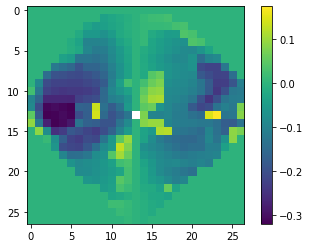

In [107]:
xs_contri = norm_xs * maxs[144:171,43:70].T
plt.imshow(xs_contri)
plt.colorbar()

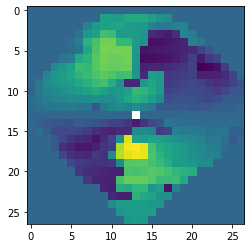

In [108]:
ys_contri = norm_ys * maxs[144:171,43:70].T
plt.imshow(ys_contri)

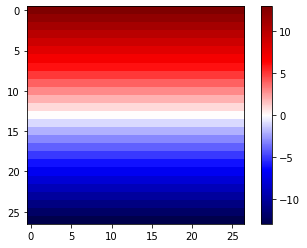

In [50]:
# create x-axis
b = np.asarray(list(range(-13,14)))
b = b[:,np.newaxis]
xs = np.repeat(b, 27, axis = 1)
xs = xs[::-1,:]
plt.imshow(ys,cmap='seismic')
plt.colorbar()

In [57]:
import math

In [68]:
math.sqrt(xs[0][0]**2 *2)

18.384776310850235

In [72]:
xs.shape

(27, 27)

In [66]:
# calculate the length array of xs
for i,j in xs and ys:
    
c = math.sqrt((xs[0][0])**2 + (ys[0][0])**2)


18.384776310850235

In [70]:
xs[0]/c

array([0.70710678, 0.70710678, 0.70710678, 0.70710678, 0.70710678,
       0.70710678, 0.70710678, 0.70710678, 0.70710678, 0.70710678,
       0.70710678, 0.70710678, 0.70710678, 0.70710678, 0.70710678,
       0.70710678, 0.70710678, 0.70710678, 0.70710678, 0.70710678,
       0.70710678, 0.70710678, 0.70710678, 0.70710678, 0.70710678,
       0.70710678, 0.70710678])